In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy, os, time, sys, h5py, pickle, argparse
from sklearn.cross_decomposition import PLSRegression
from skimage.transform import resize as imresize
from tqdm import tqdm

# Look at the images

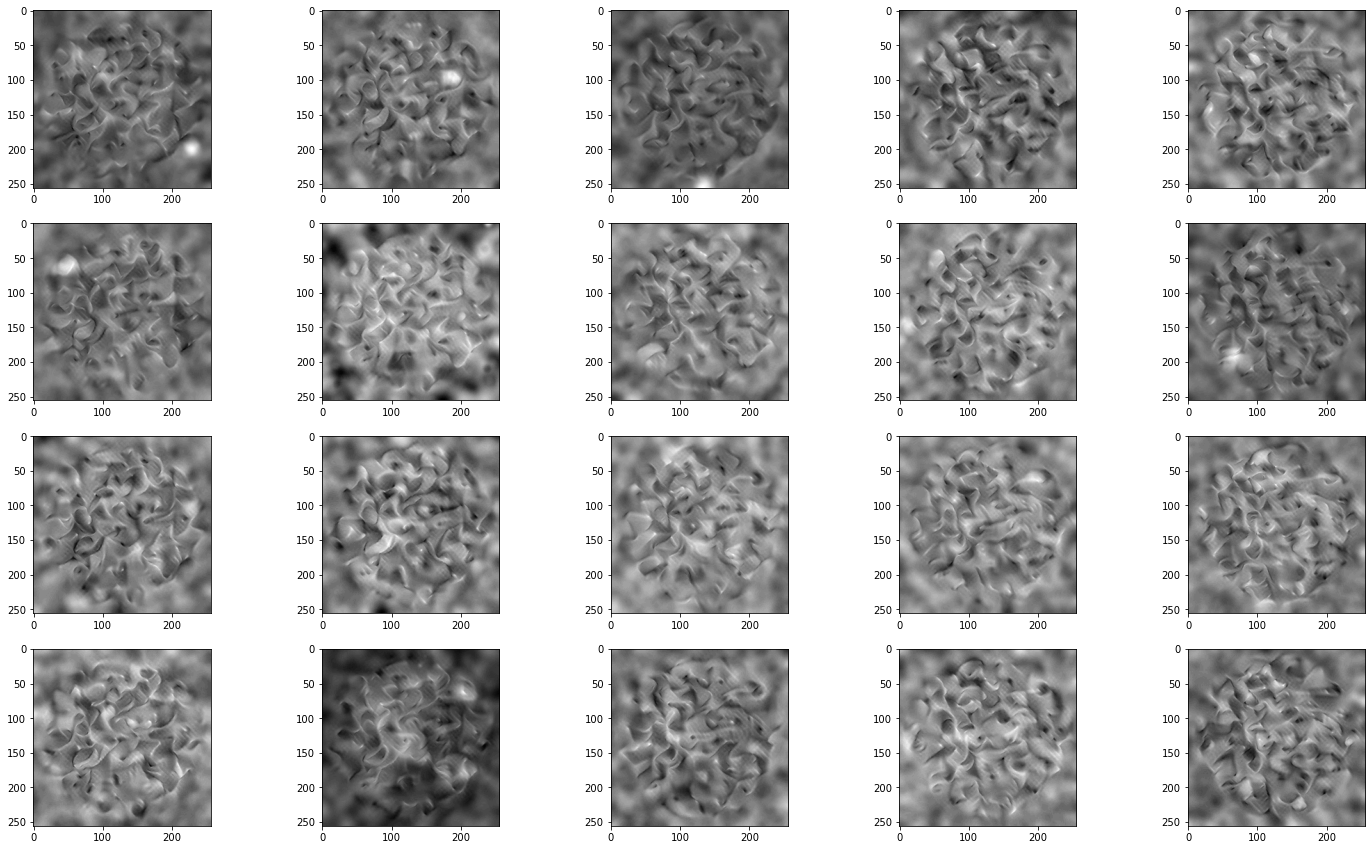

In [47]:
image_pairs = ['horse_cat', 'elephant1_face1', 'rocks_leaves']
layerareas = ['pool3-V1', 'pool4-IT']

def plot_interpol_images(image_pair, layerarea='pool3-V1', nSamples=3, bw=True):
    image_dir = '/home/gru/akshay/neurint/outputs'
    intervals = [0, 25, 50, 75, 100]
    samples = [1,2,3,4]

    if bw:
        image_dir += '/bw'
    else:
        image_dir += '/color'
    fig, axes = plt.subplots(len(samples), len(intervals), figsize=(25,15))
    for si, sample in enumerate(samples):
        for ii, interval in enumerate(intervals):
            ax = axes[si,ii]
            filename = f'{image_dir}/{image_pair}_{interval}_{layerarea}_s{sample}.png'
            if not os.path.isfile(filename):
                continue
            img = Image.open(filename)
            ax.imshow(img, cmap='gray')
plot_interpol_images(image_pairs[0], layerareas[0])

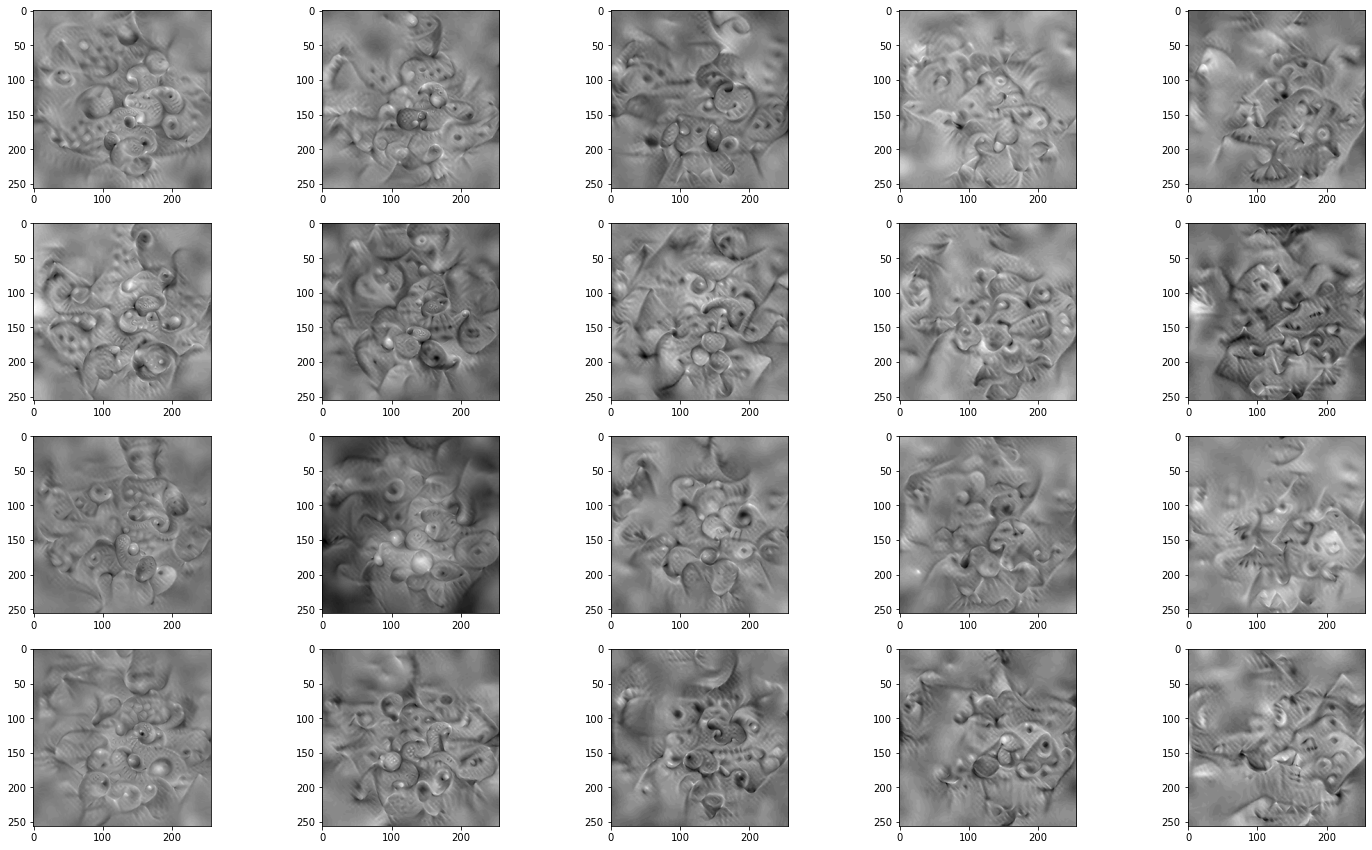

In [50]:
plot_interpol_images(image_pairs[2], layerareas[1])

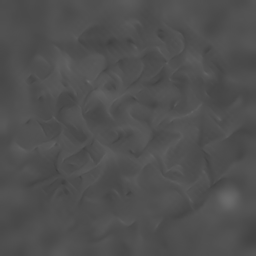

In [41]:
x

In [54]:
def load_v1_data(v1_data_path):
    with open(v1_data_path, 'rb') as f:
        v1_data = pickle.load(f)
    
    # responses: 7250 (nImages) x 166 (nNeurons)
    responses = np.nanmean(v1_data['responses'], axis=0) 
    
    # images: 7250 (nImages) x 140 (width) x 140 (height)
    images = v1_data['images']
    
    return responses, images

In [56]:
responses, images = load_v1_data('neural_data/cadena_ploscb_data.pkl')

<ipython-input-54-3b49f558b588>:6: RuntimeWarning: Mean of empty slice
  responses = np.nanmean(v1_data['responses'], axis=0)


In [75]:
responses.shape

(7250, 166)

nan

In [76]:
from IT_neural_fit import generate_shuffle

train_, test_ = generate_shuffle(responses.shape[0])

In [129]:
nan_idx = np.where(np.isnan(responses[:,0]))[0]
np.setdiff1d(test_, nan_idx).shape

(1813,)

In [131]:
print(train_.shape)
print(len(nan_idx)>0)

(5437,)
False


In [19]:
with open('model_fits/V1_vgg19_pool3-fit_5-components.pickle', 'rb') as f:
    fit = pickle.load(f)
    

In [18]:
262144 / 65536

4.0

In [21]:
#for i in fit['v1_weights'][0]:
#    print(i.shape)

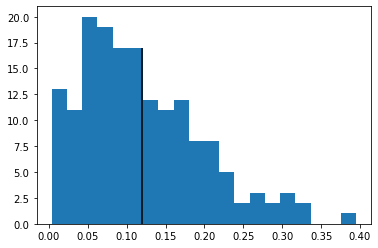

In [153]:

testR = np.square(np.squeeze(fit['v1_test']))
plt.hist(testR, 20)
plt.vlines(np.mean(testR), 0, 17, 'k')

In [8]:
[(i,v1_data[i].shape) for i in v1_data]

[('repetitions', (166,)),
 ('subject_id', (166,)),
 ('session_id', (166,)),
 ('image_ids', (7250, 1)),
 ('unit_id', (166,)),
 ('image_types', (7250, 1)),
 ('images', (7250, 140, 140)),
 ('responses', (4, 7250, 166)),
 ('image_numbers', (7250, 1))]

In [37]:
from IT_neural_fit import extract_neural_data

path_='/home/gru/akshay/ventral_neural_data.hdf5'
v4_data, it_data, variation_, images = extract_neural_data( path_ ) 


/home/gru/anaconda3/envs/akshay3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Split IT and V4 into separate files.

In [175]:
filedir = 'model_fits'
filename = 'vgg19_{}-fit_5-components_{}.pickle'
layers = ['conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4', 'pool3', 
          'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'pool4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5', 
          'fc6', 'fc7', 'fc8']
vers = ['V0', 'V3', 'V6']

for layer in layers:
    for ver in vers:
        fn = filename.format(layer, ver)
        if not os.path.isfile(f'{filedir}/{fn}'):
            continue
        with open(f'{filedir}/{fn}', 'rb') as f:
            file = pickle.load(f)
        it_dict = dict((k, file[k]) for k in ('it_test', 'it_train', 'it_weights'))
        v4_dict = dict((k, file[k]) for k in ('v4_test', 'v4_train', 'v4_weights'))
        with open(f'{filedir}/IT_{fn}', 'wb') as handle: 
            pickle.dump(it_dict, handle) 
        with open(f'{filedir}/V4_{fn}', 'wb') as handle: 
            pickle.dump(v4_dict, handle)

{'it_test': [[0.5124207576497888,
   0.7538206665600908,
   0.4776086154367196,
   0.8931053246327917,
   0.5601868086459164,
   0.6166540850496287,
   0.5823610110979176,
   0.6124253380435531,
   0.5790314670775555,
   0.41211553250616617,
   0.7668215935946908,
   0.09817710050677977,
   0.7325980037144771,
   0.028221447120849338,
   0.5044469010130601,
   0.27599792409669766,
   0.7576290991586385,
   0.32984228952400796,
   0.7488862119661774,
   0.4340220758017929,
   0.7619145453184498,
   0.6443760796284754,
   0.6629224119590024,
   0.8340096238511704,
   0.4184828348474205,
   0.5835816651315658,
   0.3288642477200623,
   0.1092869365853235,
   0.4139318881017987,
   0.5477427182315527,
   0.15265258729657277,
   0.297425279397436,
   0.3675939454190738,
   0.27567332761293506,
   0.055345457949354346,
   0.10198078225024475,
   0.18390472548333825,
   0.44286294679689964,
   0.14557415444929825,
   0.6194717708254659,
   0.5840024501528719,
   0.5282416259168189,
   0.82180